# Loading Data

**Author:** [Angus Mackenzie](https://github.com/AngusTheMack) ([1106817@students.wits.ac.za](mailto:1106817@students.wits.ac.za))

**Achievement** Following the [loading data](https://www.tensorflow.org/tutorials/load_data/images) tutorial from Tensorflow, and loading in augmented data to feed into models.

## Introduction
Despite using the `visualising_data` notebook, to get an overall feel for the dataset, the method used in that notebook of loading in data would be slow. Hence, this notebook is used as a means of looking into alternatives. 


System details for reproducibility:

In [1]:
%load_ext watermark
%watermark

2019-10-01T21:08:40+02:00

CPython 3.6.7
IPython 7.8.0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-21-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit


In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
tf.__version__

'2.0.0'

In [6]:
data_dir = "../../data/train"

In [7]:
def check_dataset_images(data_dir):
    """
    Some images in the dataset are corrupted or do not have any data, this method removes them
    """
    for i in os.listdir(data_dir):
        for j in os.listdir(os.path.join(data_dir, i)):
            try:
                img = Image.open(os.path.join(os.path.join(data_dir, i), j)) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                print(j,"not real image - removing")
                if os.path.exists(os.path.join(os.path.join(data_dir, i), j)):
                    os.remove(os.path.join(os.path.join(data_dir, i), j))

In [8]:
check_dataset_images(data_dir)

In [4]:
image_count = 0
CLASS_NAMES = []
for f in os.listdir(data_dir):
    CLASS_NAMES.append(f)
    image_count += len(os.listdir(os.path.join(data_dir, f)))
CLASS_NAMES = np.array(CLASS_NAMES)
print(CLASS_NAMES)
image_count

['class-957' 'class-697' 'class-239' 'class-140' 'class-362' 'class-811'
 'class-540' 'class-460' 'class-1625' 'class-663' 'class-67' 'class-526'
 'class-854' 'class-734' 'class-629' 'class-639' 'class-273' 'class-653'
 'class-204' 'class-635' 'class-597' 'class-561' 'class-804' 'class-1059'
 'class-536' 'class-771' 'class-78' 'class-390' 'class-784' 'class-72'
 'class-966' 'class-707' 'class-326' 'class-872' 'class-857' 'class-394'
 'class-543' 'class-128' 'class-654' 'class-4' 'class-581' 'class-448'
 'class-337' 'class-508' 'class-450']


82417

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [7]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 82417 images belonging to 45 classes.


In [18]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

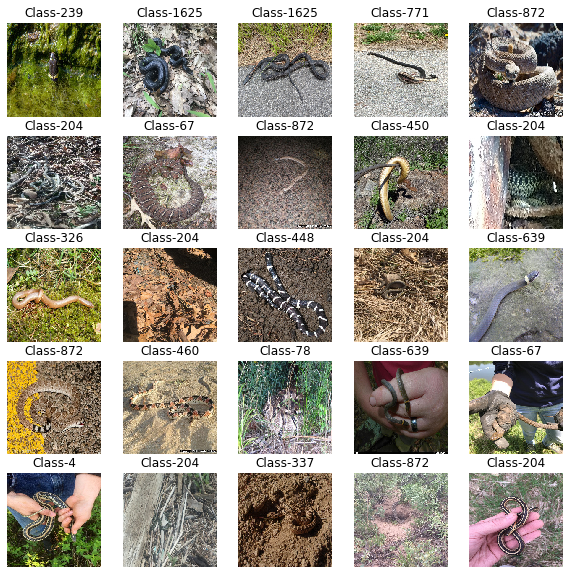

In [9]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Using Tf.Data

In [8]:
list_ds = tf.data.Dataset.list_files(data_dir+"/*/*")

In [9]:
for f in list_ds.take(5):
      print(f.numpy())

b'../../data/train/class-460/5d83952a739aba53491ad5df190cc4dd.jpg'
b'../../data/train/class-771/23a6b1269fc69dc40e01f733b59e3c83.jpg'
b'../../data/train/class-4/96bfa9837632debe5f175f8f88fbbaad.jpg'
b'../../data/train/class-448/35e94c730c3c2ab739ab3769778dcd46.jpg'
b'../../data/train/class-204/b8ca5a2093fe6038e0e39110e596baab.jpg'


In [10]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [11]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False]


In [15]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [16]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

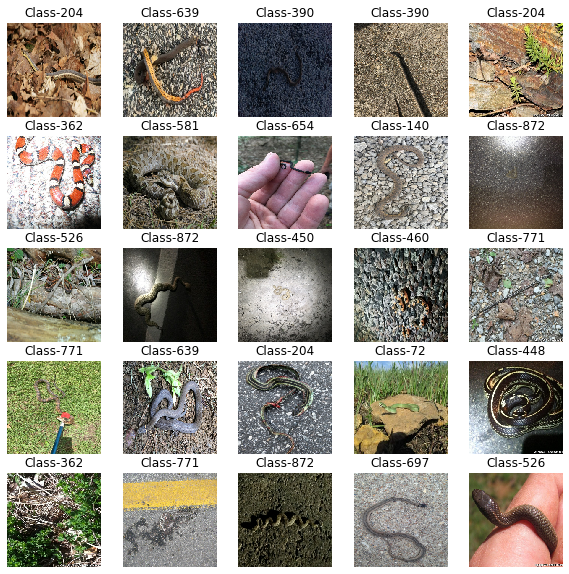

In [19]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [24]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [23]:
# `keras.preprocessing`
timeit(train_data_gen)

....................
200 batches: 59.2693772315979 s
107.98156 Images/s


In [ ]:
# `tf.data`
timeit(train_ds)

.....................................................